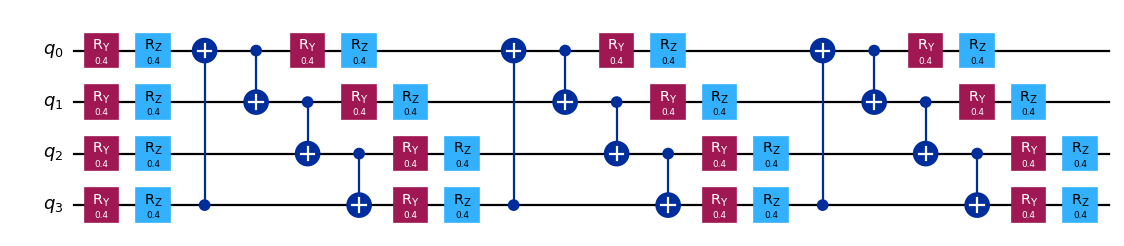

In [5]:
from qiskit.circuit.library import efficient_su2

circuit = efficient_su2(num_qubits=4, entanglement="circular")
circuit.assign_parameters([0.4] * len(circuit.parameters), inplace=True)
circuit.draw("mpl", scale=0.8)

In [6]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp(["ZZII", "IZZI", "-IIZZ", "XIXI", "ZIZZ", "IXIX"])

In [7]:
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

backend = FakeManilaV2()

In [8]:
from qiskit.transpiler import generate_preset_pass_manager

pass_manager = generate_preset_pass_manager(
    optimization_level=1, backend=backend, initial_layout=[0, 1, 2, 3]
)

transpiled_qc = pass_manager.run(circuit)
print(f"Transpiled circuit depth: {transpiled_qc.depth(lambda x: len(x[1]) >= 2)}")

Transpiled circuit depth: 30


/tmp/ipykernel_146918/3423257129.py:8: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  print(f"Transpiled circuit depth: {transpiled_qc.depth(lambda x: len(x[1]) >= 2)}")


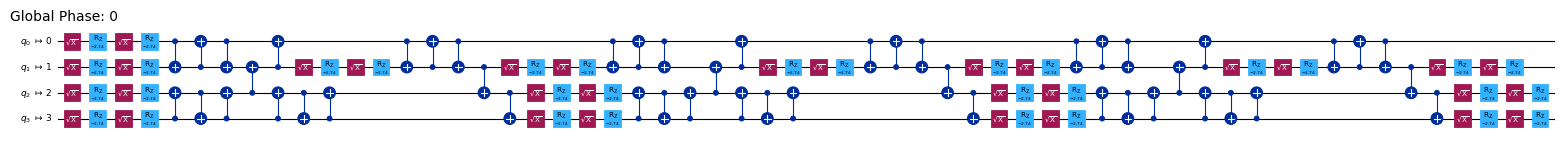

In [9]:
transpiled_qc.draw("mpl", scale=0.4, idle_wires=False, fold=-1)

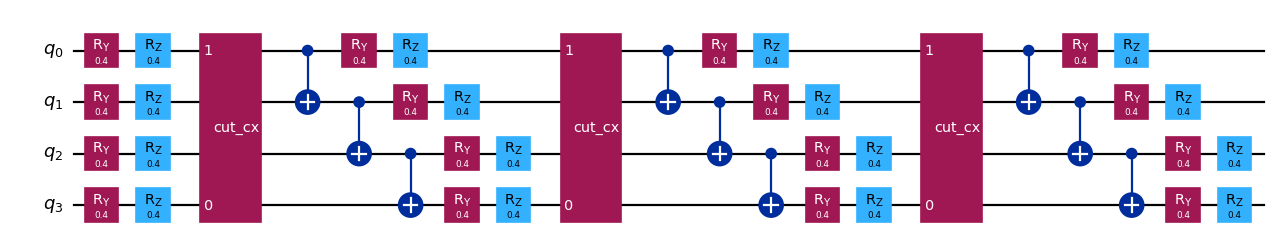

In [10]:
from qiskit_addon_cutting import cut_gates

# Find the indices of the distant gates
cut_indices = [
    i
    for i, instruction in enumerate(circuit.data)
    if {circuit.find_bit(q)[0] for q in instruction.qubits} == {0, 3}
]

# Decompose distant CNOTs into TwoQubitQPDGate instances
qpd_circuit, bases = cut_gates(circuit, cut_indices)

qpd_circuit.draw("mpl", scale=0.8)

In [11]:
import numpy as np
from qiskit_addon_cutting import generate_cutting_experiments

# Generate the subexperiments and sampling coefficients
subexperiments, coefficients = generate_cutting_experiments(
    circuits=qpd_circuit, observables=observable.paulis, num_samples=np.inf
)

In [12]:
print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")

Sampling overhead: 729.0


Original circuit depth after transpile: 30
QPD subexperiment depth after transpile: 7


/tmp/ipykernel_146918/4252024425.py:5: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  f"Original circuit depth after transpile: {transpiled_qc.depth(lambda x: len(x[1]) >= 2)}"
/tmp/ipykernel_146918/4252024425.py:8: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  f"QPD subexperiment depth after transpile: {transpiled_qpd_circuit.depth(lambda x: len(x[1]) >= 2)}"


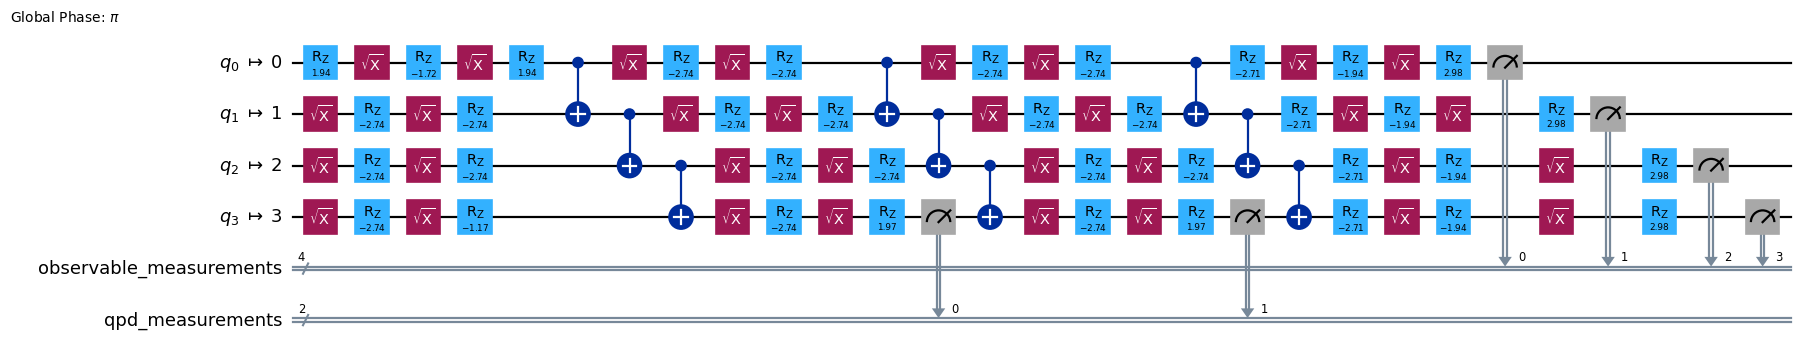

In [13]:
# Transpile the decomposed circuit to the same layout
transpiled_qpd_circuit = pass_manager.run(subexperiments[100])

print(
    f"Original circuit depth after transpile: {transpiled_qc.depth(lambda x: len(x[1]) >= 2)}"
)
print(
    f"QPD subexperiment depth after transpile: {transpiled_qpd_circuit.depth(lambda x: len(x[1]) >= 2)}"
)
transpiled_qpd_circuit.draw("mpl", scale=0.8, idle_wires=False, fold=-1)

In [14]:
# Transpile the subeperiments to the backend's instruction set architecture (ISA)
isa_subexperiments = pass_manager.run(subexperiments)

In [15]:
from qiskit_ibm_runtime import SamplerV2

# Set up the Qiskit Runtime Sampler primitive.  For a fake backend, this will use a local simulator.
sampler = SamplerV2(backend)

# Submit the subexperiments
job = sampler.run(isa_subexperiments)

In [16]:
# Retrieve the results
results = job.result()

In [17]:
from qiskit_addon_cutting import reconstruct_expectation_values

reconstructed_expval_terms = reconstruct_expectation_values(
    results,
    coefficients,
    observable.paulis,
)
# Reconstruct final expectation value
reconstructed_expval = np.dot(reconstructed_expval_terms, observable.coeffs)

In [18]:
from qiskit_aer.primitives import EstimatorV2

estimator = EstimatorV2()
exact_expval = estimator.run([(circuit, observable)]).result()[0].data.evs
print(f"Reconstructed expectation value: {np.real(np.round(reconstructed_expval, 8))}")
print(f"Exact expectation value: {np.round(exact_expval, 8)}")
print(f"Error in estimation: {np.real(np.round(reconstructed_expval-exact_expval, 8))}")
print(
    f"Relative error in estimation: {np.real(np.round((reconstructed_expval-exact_expval) / exact_expval, 8))}"
)

Reconstructed expectation value: 0.44775391
Exact expectation value: 0.50497603
Error in estimation: -0.05722213
Relative error in estimation: -0.11331652
